C:\Users\ACER\AppData\Local\Temp\ipykernel_16396\1826049994.py:6: DtypeWarning: Columns (13,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/race_result_cleaned.csv')


=== 1. Cek Distribusi Target (Rank) ===


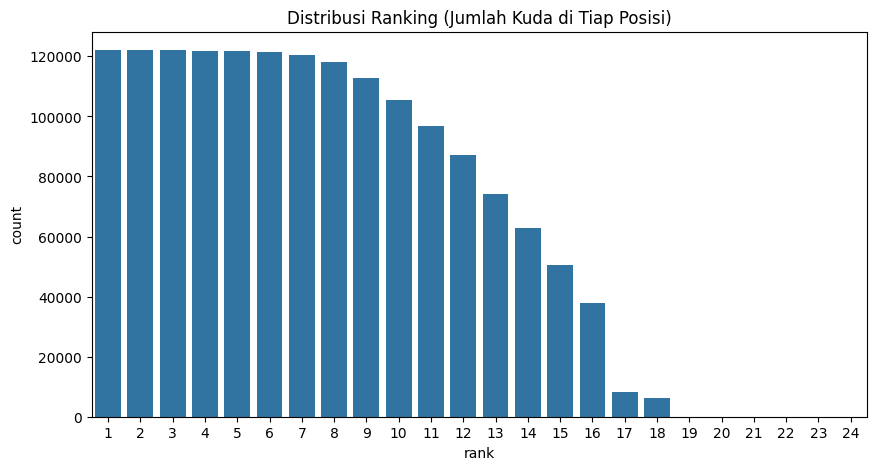

=== 2. Cek Hubungan Odds vs Rank ===


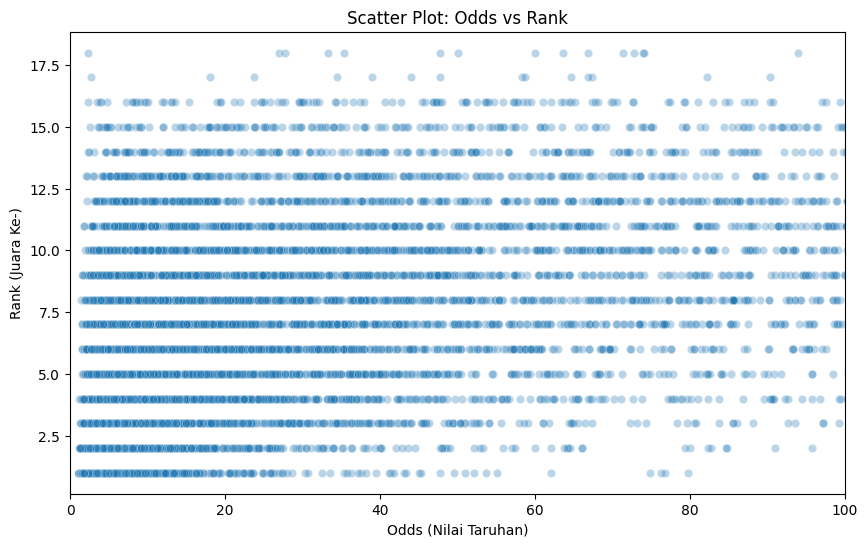

=== 3. Cek Korelasi Fitur Numerik ===


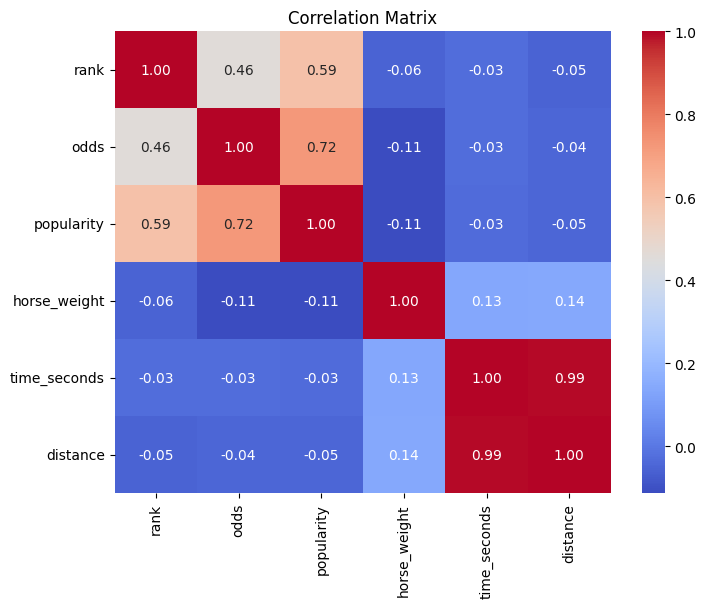

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Gunakan data bersih yang sudah disimpan
df = pd.read_csv('../data/processed/race_result_cleaned.csv')

print("=== 1. Cek Distribusi Target (Rank) ===")
# Apakah data Ranking tersebar merata?
plt.figure(figsize=(10, 5))
sns.countplot(x='rank', data=df)
plt.title("Distribusi Ranking (Jumlah Kuda di Tiap Posisi)")
plt.show()

print("=== 2. Cek Hubungan Odds vs Rank ===")
# Apakah kuda favorit (Odds rendah) cenderung juara?
# Kita ambil sampel 10.000 data saja biar plot tidak berat
subset = df.sample(10000)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odds', y='rank', data=subset, alpha=0.3)
plt.xlim(0, 100) # Fokus pada odds 0-100
plt.title("Scatter Plot: Odds vs Rank")
plt.xlabel("Odds (Nilai Taruhan)")
plt.ylabel("Rank (Juara Ke-)")
plt.show()

print("=== 3. Cek Korelasi Fitur Numerik ===")
# Fitur apa yang paling berhubungan dengan Ranking?
corr_cols = ['rank', 'odds', 'popularity', 'horse_weight', 'time_seconds', 'distance']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [10]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

# Setup tqdm
tqdm.pandas()

# 1. Load Data Bersih
# parse_dates penting agar kolom 'date' langsung jadi tipe datetime
df = pd.read_csv('../data/processed/race_result_cleaned.csv', parse_dates=['date'])

print(f"Total Data Awal: {len(df)} baris")

# ==========================================
# [SISIPKAN FILTER DI SINI]
# ==========================================
# Filter: Ambil hanya Flat Race (Buang Jump Race)
# Tanda '~' artinya "KECUALI" atau "NEGASI"
# Pastikan Anda sudah menjalankan Mapping di Notebook 01 agar 'Jump' terdeteksi di race_class
df = df[~df['race_class'].str.contains('Jump', case=False, na=False)]

print(f"Sisa Data (Flat Race Only): {len(df)} baris")
# ==========================================

# 2. PENTING: Urutkan data berdasarkan Kuda dan Tanggal
# Kita butuh urutan waktu yang benar untuk menghitung sejarah (masa lalu -> masa kini)
# reset_index(drop=True) wajib agar index kembali rapi dari 0, 1, 2... setelah pembuangan data
df = df.sort_values(by=['horse_name', 'date']).reset_index(drop=True)

df.head(3)

C:\Users\ACER\AppData\Local\Temp\ipykernel_16396\4263686909.py:11: DtypeWarning: Columns (13,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/race_result_cleaned.csv', parse_dates=['date'])


Total Data Awal: 1611896 baris
Sisa Data (Flat Race Only): 1561206 baris


,race_id,date,start_time,venue,holding_number,holding_days,race_name,race_class,race_type,grade_race_count,...,popularity,horse_weight,weight_change,prize,time_seconds,horse_name_eng,jockey_eng,owner_eng,trainer_eng,race_name_eng
0,201206010606,2012-01-21,12:50:00,Nakayama,1,6,3歳新馬,3yo Newcomer,NaN,NaN,...,13.0,454.0,0.0,90.0,102.6,Aiaiendebaa,Heiya Yuu,Saitou Takashi,Kojima Shigeyuki,3 Toshi Shinba
1,201205020805,2012-05-13,12:20:00,Tokyo,2,8,3歳未勝利,3yo Maiden,NaN,NaN,...,6.0,450.0,-4.0,NaN,125.8,Aiaiendebaa,Uiria,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri
2,201203020204,2012-06-17,11:40:00,Fukushima,2,2,3歳未勝利,3yo Maiden,NaN,NaN,...,9.0,444.0,-6.0,NaN,123.1,Aiaiendebaa,Tanaka Katsuharu,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri


In [11]:
print("--- Membuat Fitur: Rotation (Interval) ---")
# Urutkan data berdasarkan Nama Kuda dan Tanggal agar 'shift' mengambil data masa lalu yang benar
df = df.sort_values(by=['horse_name', 'date'], ascending=[True, True])

# 1. Hitung tanggal balapan sebelumnya untuk setiap kuda
df['prev_date'] = df.groupby('horse_name')['date'].shift(1)

# 2. Hitung selisih hari (Date Sekarang - Date Sebelumnya)
df['rotation_days'] = (df['date'] - df['prev_date']).dt.days

# 3. Handling NaN (Balapan Pertama Kuda Tersebut)
# Kita isi dengan -1 atau 0. Mari pakai 0 untuk MVP.
df['rotation_days'] = df['rotation_days'].fillna(0)

# Cek hasil
print("Contoh Rotation Days:")
display(df[['date', 'horse_name', 'rotation_days']].head(10))

--- Membuat Fitur: Rotation (Interval) ---
Contoh Rotation Days:


,date,horse_name,rotation_days
0,2012-01-21,アイアイエンデバー,0.0
1,2012-05-13,アイアイエンデバー,113.0
2,2012-06-17,アイアイエンデバー,35.0
3,2012-07-15,アイアイエンデバー,28.0
4,2012-08-19,アイアイエンデバー,35.0
5,2012-09-02,アイアイエンデバー,14.0
6,2012-09-29,アイアイエンデバー,27.0
7,2012-11-18,アイアイエンデバー,50.0
8,2012-12-24,アイアイエンデバー,36.0
9,2013-01-12,アイアイエンデバー,19.0


In [12]:
print("--- Membuat Fitur: History (Lag Features) [DIPERBAIKI] ---")

def create_lag_features(df):
    # [PERBAIKAN 1]: Urutkan data berdasarkan nama dan tanggal
    # Ini WAJIB agar fungsi 'shift' mengambil data masa lalu yang benar
    df = df.sort_values(by=['horse_name', 'date'], ascending=[True, True])
    
    # Kelompokkan per kuda
    grp = df.groupby('horse_name')
    
    # A. Ranking Terakhir (Last Run)
    # Shift 1 = Ranking di balapan sebelumnya
    df['last_rank'] = grp['rank'].shift(1)
    
    # B. Ranking 3 Balapan Terakhir (Rata-rata)
    # [PERBAIKAN 2]: Tambahkan 'min_periods=1'
    # Agar jika data baru ada 1 atau 2, rata-rata tetap dihitung (tidak jadi NaN)
    df['last_3_avg_rank'] = grp['rank'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
    
    # C. Total Balapan (Pengalaman)
    df['race_count'] = grp.cumcount()
    
    return df

# Jalankan fungsi
df = create_lag_features(df)

# Isi NaN (Hanya untuk kuda yang BENAR-BENAR baru pertama kali debut/balapan ke-0)
# Kuda yang sudah lari 1x tidak akan kena fillna(18) lagi di last_3_avg_rank berkat min_periods=1
df['last_rank'] = df['last_rank'].fillna(18) 
df['last_3_avg_rank'] = df['last_3_avg_rank'].fillna(18)

print("Contoh History Features (Fixed):")
display(df[['date', 'horse_name', 'rank', 'last_rank', 'last_3_avg_rank']].head(10))

--- Membuat Fitur: History (Lag Features) [DIPERBAIKI] ---
Contoh History Features (Fixed):


,date,horse_name,rank,last_rank,last_3_avg_rank
0,2012-01-21,アイアイエンデバー,4,18.0,18.000000
1,2012-05-13,アイアイエンデバー,14,4.0,4.000000
2,2012-06-17,アイアイエンデバー,8,14.0,9.000000
3,2012-07-15,アイアイエンデバー,10,8.0,8.666667
4,2012-08-19,アイアイエンデバー,2,10.0,10.666667
5,2012-09-02,アイアイエンデバー,1,2.0,6.666667
6,2012-09-29,アイアイエンデバー,8,1.0,4.333333
7,2012-11-18,アイアイエンデバー,11,8.0,3.666667
8,2012-12-24,アイアイエンデバー,4,11.0,6.666667
9,2013-01-12,アイアイエンデバー,2,4.0,7.666667


In [13]:
# Keyword pencarian 
keyword = "メジロマックイーン"

# Filter DataFrame
# na=False agar tidak error jika ada nama yang kosong
search_results = df[df['horse_name'].str.contains(keyword, case=False, na=False)]

# Urutkan berdasarkan tanggal balapan
search_results = search_results.sort_values('date')

# Tampilkan kolom-kolom penting
cols_to_show = ['date', 'race_name_eng','race_name_eng','race_class','owner_eng', 'horse_name_eng','corner_1','corner_4','last_rank', 'last_3_avg_rank','rotation_days', 'jockey_eng', 'trainer_eng','rank', 'odds', 'popularity']

print(f"Ditemukan {len(search_results)} data balapan dengan nama '{keyword}':")
display(search_results[cols_to_show])

Ditemukan 21 data balapan dengan nama 'メジロマックイーン':


,date,race_name_eng,race_name_eng,race_class,owner_eng,horse_name_eng,corner_1,corner_4,last_rank,last_3_avg_rank,rotation_days,jockey_eng,trainer_eng,rank,odds,popularity
1355045,1990-02-03,4 Toshi Shinba,4 Toshi Shinba,4yo Newcomer,Mejiro Shouji,Mejiromakkuiin,2.0,2.0,18.0,18.000000,0.0,Muramoto Yoshiyuki,Ikee Yasurou,1,3.3,2.0
1355046,1990-02-25,Yukiyanagi Shou,Yukiyanagi Shou,4yo Under 5M,Mejiro Shouji,Mejiromakkuiin,6.0,1.0,1.0,1.000000,22.0,Muramoto Yoshiyuki,Ikee Yasurou,2,2.2,1.0
1355047,1990-05-12,Ayame Shou,Ayame Shou,4yo Under 5M,Mejiro Shouji,Mejiromakkuiin,2.0,3.0,2.0,1.500000,76.0,Muramoto Yoshiyuki,Ikee Yasurou,3,1.7,1.0
1355048,1990-09-02,Watarishima Tokubetsu,Watarishima Tokubetsu,4yo+ Under 5M,Mejiro Shouji,Mejiromakkuiin,2.0,1.0,3.0,2.000000,113.0,Uchida Kouichi,Ikee Yasurou,2,1.7,1.0
1355049,1990-09-16,Kikonai Tokubetsu,Kikonai Tokubetsu,4yo+ Under 5M,Mejiro Shouji,Mejiromakkuiin,1.0,1.0,2.0,2.333333,14.0,Uchida Kouichi,Ikee Yasurou,1,1.2,1.0
1355050,1990-09-23,Oonuma Suteekusu,Oonuma Suteekusu,4yo+ Under 9M,Mejiro Shouji,Mejiromakkuiin,4.0,2.0,1.0,2.000000,7.0,Uchida Kouichi,Ikee Yasurou,1,4.1,1.0
1355051,1990-10-13,Arashiyama Suteekusu,Arashiyama Suteekusu,4yo+ Under 15M,Mejiro Shouji,Mejiromakkuiin,5.0,5.0,1.0,1.333333,20.0,Uchida Kouichi,Ikee Yasurou,2,2.4,1.0
1355052,1990-11-04,Kikkashou,Kikkashou,4yo Open,Mejiro Shouji,Mejiromakkuiin,5.0,2.0,2.0,1.333333,22.0,Uchida Kouichi,Ikee Yasurou,1,7.8,4.0
1355053,1991-03-10,Hanshindaishouten,Hanshindaishouten,4yo+ Open,Mejiro Shouji,Mejiromakkuiin,6.0,2.0,1.0,1.333333,126.0,Taketoyo,Ikee Yasurou,1,1.2,1.0
1355054,1991-04-28,Tennoushou ( Haru ),Tennoushou ( Haru ),4yo+ Open,Mejiro Shouji,Mejiromakkuiin,7.0,3.0,1.0,1.333333,49.0,Taketoyo,Ikee Yasurou,1,1.7,1.0


--- Memulai Running Style Clustering ---
Data valid untuk clustering: 645116 baris

--- Profil Cluster (Rata-rata Posisi) ---
   cluster_id   corner_1   corner_4   mean_pos
0           0   3.008867   2.930101   2.969484
2           2   8.883526   6.121842   7.502684
1           1   5.721037   9.691811   7.706424
3           3  12.583895  12.256435  12.420165

Mapping Label Otomatis: {0: 'Nige (Front)', 2: 'Senkou (Stalker)', 1: 'Sashi (Mid)', 3: 'Oikomi (Back)'}


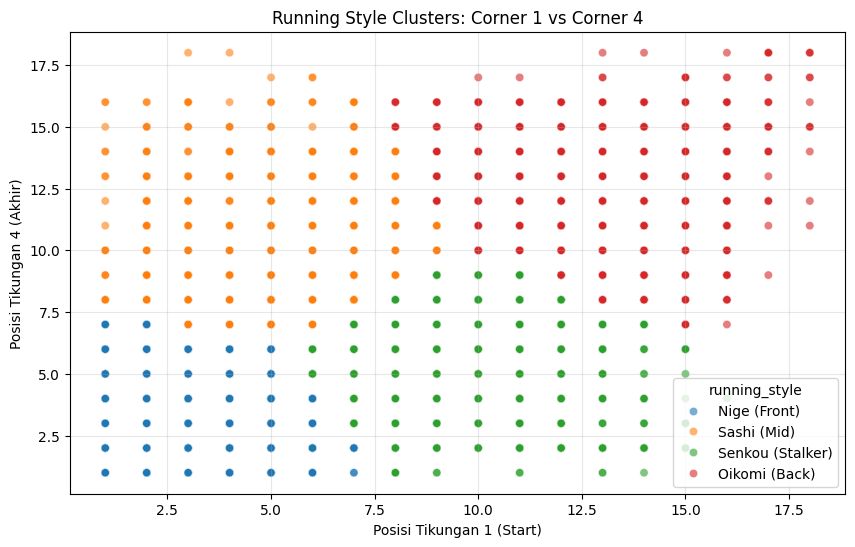


--- Hasil Akhir di Data Utama ---
running_style
Unknown             916090
Nige (Front)        248672
Senkou (Stalker)    153863
Oikomi (Back)       134459
Sashi (Mid)         108122
Name: count, dtype: int64


,horse_name,corner_1,corner_4,running_style
0,アイアイエンデバー,NaN,10.0,Unknown
1,アイアイエンデバー,NaN,14.0,Unknown
2,アイアイエンデバー,8.0,10.0,Sashi (Mid)
3,アイアイエンデバー,12.0,13.0,Oikomi (Back)
4,アイアイエンデバー,5.0,5.0,Nige (Front)
5,アイアイエンデバー,5.0,3.0,Nige (Front)
6,アイアイエンデバー,10.0,11.0,Oikomi (Back)
7,アイアイエンデバー,7.0,13.0,Sashi (Mid)
8,アイアイエンデバー,4.0,4.0,Nige (Front)
9,アイアイエンデバー,2.0,2.0,Nige (Front)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


print("--- Memulai Running Style Clustering ---")

# 2. Persiapan Data untuk Clustering
# Kita butuh data posisi tikungan.
# Ambil kolom corner. Jika NaN (kuda tidak lewat tikungan/jarak pendek), kita isi dengan posisi finish (rank) atau mean.
# Strategi: Drop baris yang corner-nya kosong untuk Training K-Means, nanti kita predict sisanya (atau biarkan -1).
cluster_cols = ['corner_1', 'corner_4'] # Corner 1 (Start) dan Corner 4 (Sebelum Finish) paling krusial.

# Filter data yang valid untuk clustering (tidak boleh ada NaN di kolom corner)
df_cluster = df.dropna(subset=cluster_cols).copy()

print(f"Data valid untuk clustering: {len(df_cluster)} baris")

# 3. Standardisasi Data (PENTING untuk K-Means)
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster[cluster_cols])

# 4. Jalankan K-Means (4 Cluster)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['cluster_id'] = kmeans.fit_predict(X)

# 5. Interpretasi Cluster (Memberi Label Manusia)
# Kita lihat rata-rata posisi tiap cluster untuk tahu dia tipe apa.
cluster_summary = df_cluster.groupby('cluster_id')[cluster_cols].mean().reset_index()
cluster_summary['mean_pos'] = (cluster_summary['corner_1'] + cluster_summary['corner_4']) / 2
cluster_summary = cluster_summary.sort_values('mean_pos') # Urutkan dari posisi terdepan (angka kecil)

print("\n--- Profil Cluster (Rata-rata Posisi) ---")
print(cluster_summary)

# Mapping Label berdasarkan urutan mean_pos:
# Cluster dengan mean_pos terendah (1-3) = Nige (Front)
# Cluster berikutnya = Senkou (Stalker)
# Cluster berikutnya = Sashi (Mid)
# Cluster dengan mean_pos tertinggi (belakang) = Oikomi (Back)

# Buat dictionary mapping otomatis
label_mapping = {}
labels = ['Nige (Front)', 'Senkou (Stalker)', 'Sashi (Mid)', 'Oikomi (Back)']

for i, cluster_id in enumerate(cluster_summary['cluster_id']):
    label_mapping[cluster_id] = labels[i]

print(f"\nMapping Label Otomatis: {label_mapping}")

# Terapkan Label ke DataFrame Cluster
df_cluster['running_style'] = df_cluster['cluster_id'].map(label_mapping)

# 6. Visualisasi Hasil (EDA Singkat)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='corner_1', y='corner_4', hue='running_style', data=df_cluster.sample(10000), alpha=0.6)
plt.title('Running Style Clusters: Corner 1 vs Corner 4')
plt.xlabel('Posisi Tikungan 1 (Start)')
plt.ylabel('Posisi Tikungan 4 (Akhir)')
plt.grid(True, alpha=0.3)
plt.show()

# 7. GABUNGKAN KEMBALI KE DATA UTAMA (Merge)
# Kita gabungkan hasil clustering ke tabel utama berdasarkan index
df['running_style'] = df_cluster['running_style']
# Isi NaN (yang tadi tidak ikut clustering) dengan 'Unknown'
df['running_style'] = df['running_style'].fillna('Unknown')

# Cek hasil di tabel utama
print("\n--- Hasil Akhir di Data Utama ---")
print(df['running_style'].value_counts())
display(df[['horse_name', 'corner_1', 'corner_4', 'running_style']].head(10))

# 8. Encoding untuk Model (Opsional, jika mau dipakai training langsung)
# Ubah string 'Nige', 'Senkou' jadi angka 0, 1, 2, 3
style_encoder = {v: k for k, v in enumerate(labels)}
style_encoder['Unknown'] = -1
df['running_style_id'] = df['running_style'].map(style_encoder)

In [15]:
# Keyword pencarian 
keyword = "ダイワドンクール"

# Filter DataFrame
# na=False agar tidak error jika ada nama yang kosong
search_results = df_cluster[df_cluster['horse_name'].str.contains(keyword, case=False, na=False)]

# Urutkan berdasarkan tanggal balapan
search_results = search_results.sort_values('date')

# Tampilkan kolom-kolom penting
cols_to_show = ['date', 'race_name_eng','race_name_eng','race_class','owner_eng', 'horse_name_eng','running_style','corner_1','corner_4', 'jockey_eng', 'trainer_eng','rank', 'odds', 'popularity']

print(f"Ditemukan {len(search_results)} data balapan dengan nama '{keyword}':")
display(search_results[cols_to_show])

Ditemukan 6 data balapan dengan nama 'ダイワドンクール':


,date,race_name_eng,race_name_eng,race_class,owner_eng,horse_name_eng,running_style,corner_1,corner_4,jockey_eng,trainer_eng,rank,odds,popularity
748187,1991-01-12,4 Toshi Mishouri,4 Toshi Mishouri,4yo Maiden,Yamato Shouji,Daiwadonkuuru,Nige (Front),5.0,6.0,Sawa Akinori,Ogata Moritsugu,1,8.8,5.0
748189,1991-02-23,Suisen Shou,Suisen Shou,4yo Under 5M,Yamato Shouji,Daiwadonkuuru,Sashi (Mid),5.0,7.0,Tanaka Katsuharu,Ogata Moritsugu,1,8.9,5.0
748190,1991-03-17,Wakaba Suteekusu,Wakaba Suteekusu,4yo Open,Yamato Shouji,Daiwadonkuuru,Sashi (Mid),6.0,10.0,Tanaka Katsuharu,Ogata Moritsugu,10,39.2,7.0
748194,1991-08-18,Nihonkai Suteekusu,Nihonkai Suteekusu,4yo+ Under 9M,Yamato Shouji,Daiwadonkuuru,Nige (Front),3.0,4.0,Eda Teruo,Ogata Moritsugu,11,15.6,7.0
748195,1991-09-01,Sado Suteekusu,Sado Suteekusu,4yo+ Under 9M,Yamato Shouji,Daiwadonkuuru,Sashi (Mid),5.0,8.0,Eda Teruo,Ogata Moritsugu,6,14.0,6.0
748196,1991-09-22,Inubouzaki Tokubetsu,Inubouzaki Tokubetsu,4yo+ Under 9M,Yamato Shouji,Daiwadonkuuru,Nige (Front),4.0,2.0,Eda Teruo,Ogata Moritsugu,8,26.5,7.0


In [16]:
pd.set_option('display.max_columns', None)

# Sekarang panggil df.head()
print(df.head())

        race_id       date start_time      venue  holding_number  \
0  201206010606 2012-01-21   12:50:00   Nakayama               1   
1  201205020805 2012-05-13   12:20:00      Tokyo               2   
2  201203020204 2012-06-17   11:40:00  Fukushima               2   
3  201204020204 2012-07-15   11:40:00    Niigata               2   
4  201204030403 2012-08-19   11:10:00    Niigata               3   

   holding_days race_name    race_class race_type  grade_race_count surface  \
0             6      3歳新馬  3yo Newcomer       NaN               NaN    Turf   
1             8     3歳未勝利    3yo Maiden       NaN               NaN    Turf   
2             2     3歳未勝利    3yo Maiden       NaN               NaN    Turf   
3             2     3歳未勝利    3yo Maiden       NaN               NaN    Dirt   
4             4     3歳未勝利    3yo Maiden       NaN               NaN    Dirt   

   distance course_direction course_track     weather track_condition  \
0      1600            Right        Outer  

In [17]:
print("--- Label Encoding (Kategori -> Angka) ---")

# Daftar kolom kategori yang perlu diubah
cat_cols = ['venue', 'weather', 'surface', 'course_direction', 'race_class', 'sex']
# Note: horse_name, jockey, trainer biarkan dulu (bisa pakai ID atau target encoding nanti)

le = LabelEncoder()

for col in cat_cols:
    # Isi NaN dengan 'Unknown' dulu biar encoder tidak error
    df[col] = df[col].fillna('Unknown')
    
    # Fit & Transform
    df[col + '_id'] = le.fit_transform(df[col].astype(str))
    print(f" > {col} di-encode menjadi {col}_id")

# Cek hasil
display(df[['venue', 'venue_id', 'weather', 'weather_id']].head())

--- Label Encoding (Kategori -> Angka) ---
 > venue di-encode menjadi venue_id
 > weather di-encode menjadi weather_id
 > surface di-encode menjadi surface_id
 > course_direction di-encode menjadi course_direction_id
 > race_class di-encode menjadi race_class_id
 > sex di-encode menjadi sex_id


,venue,venue_id,weather,weather_id
0,Nakayama,6,Light Rain,1
1,Tokyo,9,Sunny,5
2,Fukushima,1,Cloudy,0
3,Niigata,7,Rain,3
4,Niigata,7,Sunny,5


In [18]:
# --- FUNGSI PERBAIKAN (ANTI-LEAKAGE) ---
def create_interaction_features_safe(df, col1, col2, target_col='rank'):
    feature_name = f"{col1}_{col2}_win_rate"
    
    # 1. Pastikan Data Terurut Waktu
    # Ini WAJIB agar expanding window bekerja mundur ke masa lalu yang benar
    if 'date' in df.columns and 'race_id' in df.columns:
        df = df.sort_values(['date', 'race_id'])
    
    # 2. Buat Kolom Target Biner (1 = Menang, 0 = Kalah)
    # Kita butuh ini untuk perhitungan mean
    binary_target = (df[target_col] == 1).astype(int)
    
    # 3. Hitung Statistik 'Expanding' per Grup
    # - groupby: Kelompokkan misal per (Joki, Venue)
    # - shift(1): GESER 1 baris ke bawah. Ini kuncinya! 
    #             Data baris ini TIDAK boleh dihitung dari dirinya sendiri.
    # - expanding().mean(): Hitung rata-rata kumulatif dari awal sampai sebelum baris ini.
    
    print(f"Sedang memproses fitur: {feature_name} ...")
    
    df[feature_name] = df.groupby([col1, col2])[target_col].transform(
        lambda x: (x == 1).astype(int).shift(1).expanding().mean()
    )
    
    # 4. Handling Missing Values (NaN)
    # Baris pertama setiap kombinasi pasti NaN (karena di-shift).
    # Kita isi dengan rata-rata global masa lalu (kumulatif global) atau rata-rata konstan.
    
    # Opsi A: Isi dengan 0 (Anggap belum pernah menang) -> Lebih Aman
    df[feature_name] = df[feature_name].fillna(0)
    
    return df

# --- IMPLEMENTASI ---

# Pastikan 'rank' adalah data asli, bukan hasil prediksi
# Reset index agar aman
df = df.reset_index(drop=True)

# Terapkan Aturan
df = create_interaction_features_safe(df, 'jockey', 'venue')   # Rule 1
df = create_interaction_features_safe(df, 'trainer', 'venue')  # Rule 2
df = create_interaction_features_safe(df, 'jockey', 'distance') # Rule 3

print("Feature Engineering Selesai (Versi Aman).")

# Cek Hasil
# Perhatikan baris-baris awal untuk kombinasi tertentu, nilainya harus 0 atau kecil,
# dan perlahan naik seiring waktu.
print(df[['date', 'jockey', 'venue', 'jockey_venue_win_rate']].head(10))

Sedang memproses fitur: jockey_venue_win_rate ...
Sedang memproses fitur: trainer_venue_win_rate ...
Sedang memproses fitur: jockey_distance_win_rate ...
Feature Engineering Selesai (Versi Aman).
              date jockey     venue  jockey_venue_win_rate
2725    1986-01-05   岡部幸雄  Nakayama                    0.0
393505  1986-01-05    鈴木寿  Nakayama                    0.0
565352  1986-01-05   中舘英二  Nakayama                    0.0
586762  1986-01-05   坂井千明  Nakayama                    0.0
697520  1986-01-05    的場均  Nakayama                    0.0
707520  1986-01-05   大塚栄三  Nakayama                    0.0
785798  1986-01-05    本間忍  Nakayama                    0.0
1091890 1986-01-05   安田富男  Nakayama                    0.0
1237379 1986-01-05   石神富士  Nakayama                    0.0
1250835 1986-01-05   原田俊彦  Nakayama                    0.0


In [19]:
print("--- Memulai Sequence Discovery: Pola Rotasi (Rotation Patterns) ---")

def create_rotation_sequence(df, break_threshold=90):
    """
    Menghitung ini balapan ke-berapa setelah istirahat panjang.
    break_threshold: Jumlah hari istirahat yang dianggap "Libur Panjang" (default 3 bulan/90 hari).
    """
    # Pastikan data terurut berdasarkan Kuda dan Tanggal
    df = df.sort_values(by=['horse_name', 'date'])
    
    # 1. Identifikasi "Comeback" (Balapan pertama setelah libur > 90 hari atau Debut)
    # Jika rotation_days > 90 atau NaN (debut), maka True
    df['is_comeback'] = (df['rotation_days'] > break_threshold) | (df['rotation_days'].isna())
    
    # 2. Buat ID Kampanye (Campaign ID)
    # Setiap kali ketemu 'is_comeback', counter bertambah.
    # Ini mengelompokkan satu musim balapan (dari comeback sampai istirahat lagi).
    df['campaign_id'] = df.groupby('horse_name')['is_comeback'].cumsum()
    
    # 3. Hitung Urutan dalam Kampanye
    # Balapan ke-1 setelah libur, ke-2, ke-3, dst.
    df['race_seq_since_break'] = df.groupby(['horse_name', 'campaign_id']).cumcount() + 1
    
    # Hapus kolom bantuan
    df.drop(columns=['is_comeback', 'campaign_id'], inplace=True)
    
    return df

# --- EKSEKUSI ---
df = create_rotation_sequence(df)

print("Fitur Sequence Selesai.")
print("Contoh Kuda yang baru istirahat panjang (Cek kolom 'race_seq_since_break'):")

# Tampilkan contoh data untuk verifikasi
# Cari kuda yang rotation_days-nya > 100 hari untuk melihat efeknya
try:
    example_horse = df[df['rotation_days'] > 100].iloc[0]['horse_name']
    cols_seq = ['date', 'horse_name_eng', 'rotation_days', 'race_seq_since_break', 'rank']
    display(df[df['horse_name'] == example_horse][cols_seq].head(5))
except:
    print("Tidak ada contoh kuda dengan istirahat > 100 hari di sampel ini.")

--- Memulai Sequence Discovery: Pola Rotasi (Rotation Patterns) ---
Fitur Sequence Selesai.
Contoh Kuda yang baru istirahat panjang (Cek kolom 'race_seq_since_break'):


,date,horse_name_eng,rotation_days,race_seq_since_break,rank
0,2012-01-21,Aiaiendebaa,0.0,1,4
1,2012-05-13,Aiaiendebaa,113.0,1,14
2,2012-06-17,Aiaiendebaa,35.0,2,8
3,2012-07-15,Aiaiendebaa,28.0,3,10
4,2012-08-19,Aiaiendebaa,35.0,4,2


In [20]:
# Keyword pencarian 
keyword = "メジロマックイーン"

# Filter DataFrame
# na=False agar tidak error jika ada nama yang kosong
search_results = df[df['horse_name'].str.contains(keyword, case=False, na=False)]

# Urutkan berdasarkan tanggal balapan
search_results = search_results.sort_values('date')

# Tampilkan kolom-kolom penting
cols_to_show = ['date', 'race_name_eng','race_name_eng','race_class','race_type','surface','owner_eng', 'horse_name_eng','running_style','last_rank', 'last_3_avg_rank','rotation_days','race_seq_since_break', 'jockey_eng','jockey_venue_win_rate', 'trainer_eng','rank', 'odds', 'popularity']

print(f"Ditemukan {len(search_results)} data balapan dengan nama '{keyword}':")
display(search_results[cols_to_show])

Ditemukan 21 data balapan dengan nama 'メジロマックイーン':


,date,race_name_eng,race_name_eng,race_class,race_type,surface,owner_eng,horse_name_eng,running_style,last_rank,last_3_avg_rank,rotation_days,race_seq_since_break,jockey_eng,jockey_venue_win_rate,trainer_eng,rank,odds,popularity
1355045,1990-02-03,4 Toshi Shinba,4 Toshi Shinba,4yo Newcomer,NaN,Dirt,Mejiro Shouji,Mejiromakkuiin,Nige (Front),18.0,18.000000,0.0,1,Muramoto Yoshiyuki,0.117547,Ikee Yasurou,1,3.3,2.0
1355046,1990-02-25,Yukiyanagi Shou,Yukiyanagi Shou,4yo Under 5M,NaN,Turf,Mejiro Shouji,Mejiromakkuiin,Nige (Front),1.0,1.000000,22.0,2,Muramoto Yoshiyuki,0.116694,Ikee Yasurou,2,2.2,1.0
1355047,1990-05-12,Ayame Shou,Ayame Shou,4yo Under 5M,NaN,Turf,Mejiro Shouji,Mejiromakkuiin,Nige (Front),2.0,1.500000,76.0,3,Muramoto Yoshiyuki,0.116279,Ikee Yasurou,3,1.7,1.0
1355048,1990-09-02,Watarishima Tokubetsu,Watarishima Tokubetsu,4yo+ Under 5M,NaN,Dirt,Mejiro Shouji,Mejiromakkuiin,Nige (Front),3.0,2.000000,113.0,1,Uchida Kouichi,0.114754,Ikee Yasurou,2,1.7,1.0
1355049,1990-09-16,Kikonai Tokubetsu,Kikonai Tokubetsu,4yo+ Under 5M,NaN,Dirt,Mejiro Shouji,Mejiromakkuiin,Nige (Front),2.0,2.333333,14.0,2,Uchida Kouichi,0.106667,Ikee Yasurou,1,1.2,1.0
1355050,1990-09-23,Oonuma Suteekusu,Oonuma Suteekusu,4yo+ Under 9M,NaN,Turf,Mejiro Shouji,Mejiromakkuiin,Nige (Front),1.0,2.000000,7.0,3,Uchida Kouichi,0.114943,Ikee Yasurou,1,4.1,1.0
1355051,1990-10-13,Arashiyama Suteekusu,Arashiyama Suteekusu,4yo+ Under 15M,NaN,Turf,Mejiro Shouji,Mejiromakkuiin,Nige (Front),1.0,1.333333,20.0,4,Uchida Kouichi,0.032468,Ikee Yasurou,2,2.4,1.0
1355052,1990-11-04,Kikkashou,Kikkashou,4yo Open,G1,Turf,Mejiro Shouji,Mejiromakkuiin,Nige (Front),2.0,1.333333,22.0,5,Uchida Kouichi,0.029412,Ikee Yasurou,1,7.8,4.0
1355053,1991-03-10,Hanshindaishouten,Hanshindaishouten,4yo+ Open,G2,Turf,Mejiro Shouji,Mejiromakkuiin,Nige (Front),1.0,1.333333,126.0,1,Taketoyo,0.163212,Ikee Yasurou,1,1.2,1.0
1355054,1991-04-28,Tennoushou ( Haru ),Tennoushou ( Haru ),4yo+ Open,G1,Turf,Mejiro Shouji,Mejiromakkuiin,Senkou (Stalker),1.0,1.333333,49.0,2,Taketoyo,0.150046,Ikee Yasurou,1,1.7,1.0


In [21]:
print("--- Simpan Data Siap Model ---")

# Pilih kolom-kolom yang akan dipakai training
# Kita buang kolom teks mentah, ambil ID-nya saja, plus fitur numerik baru
feature_cols = [
    'race_id', 'date', 'rank','horse_name', # Metadata Penting
    'odds', 'popularity', 'horse_weight', 'distance', 'horse_no', 'frame_no', # Fitur Asli Numerik
    'rotation_days', 'last_rank', 'last_3_avg_rank', 'race_count', # Fitur History (Lag Features)
    'race_seq_since_break','jockey_venue_win_rate','trainer_venue_win_rate','jockey_distance_win_rate', # 4. [BARU] Fitur Canggih (Sequence & Mining)
    'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 'race_class_id', 'sex_id','running_style_id' # Fitur Kategori ID
]

df_model = df[feature_cols].copy()

# Simpan
output_file = '../data/processed/master_data_modeled.csv'
df_model.to_csv(output_file, index=False)

print(f"File Modeling tersimpan: {output_file}")
print(f"Dimensi Akhir: {df_model.shape}")

--- Simpan Data Siap Model ---
File Modeling tersimpan: ../data/processed/master_data_modeled.csv
Dimensi Akhir: (1561206, 25)
